In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import gmsh
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as sps
import matplotlib as mpl

mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["font.size"] = 14
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 6
mpl.rcParams["figure.figsize"] = (6, 6)
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.5
mpl.rcParams["grid.linestyle"] = "--"
mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"

## FEM PDE Solver 

### 1-D Solver

#### $L^2$ Projection

In [2]:
L = 1.0
N = 5


def u0(x):
    return 0


def uL(x):
    return 1


x = np.linspace(0, L, N)

In [3]:
def MassAssembler1D(x):
    h = x[1:] - x[:-1]
    d = np.concat([np.zeros((1,)), h]) + np.concat([h, np.zeros((1,))])
    MD = np.diag(d / 3.0) + np.diag(h / 6.0, -1) + np.diag(h / 6.0, 1)
    return MD


def LoadAssembler1D(x, f):
    n = len(x) - 1
    b = np.zeros((n + 1,))
    h = x[1:] - x[:-1]
    d = np.concat([np.zeros((1,)), h]) + np.concat([h, np.zeros((1,))])
    b = f(x) * (d) / 2.0
    return b


def L2Projector1D(x, f):
    M = MassAssembler1D(x)
    b = LoadAssembler1D(x, f)
    Pf = np.linalg.solve(M, b)
    return Pf


def StiffnessAssembler1D(x, a, kappa):
    h = x[1:] - x[:-1]
    mid = (x[1:] + x[:-1]) / 2.0
    d = np.concat([np.zeros((1,)), a(mid) / h]) + np.concat(
        [a(mid) / h, np.zeros((1,))]
    )
    S = np.diag(d) - np.diag(a(mid) / h, -1) - np.diag(a(mid) / h, 1)
    S[0, 0] += kappa[0]
    S[-1, -1] += kappa[-1]
    return S


def SourceAssembler1D(x, f, kappa, g):
    b = LoadAssembler1D(x, f)
    b[0] += kappa[0] * g[0]
    b[-1] += kappa[1] * g[1]
    return b


def PoissonSolver1D(x, kappa, g, cond, source):
    A = StiffnessAssembler1D(x, cond, kappa)
    b = SourceAssembler1D(x, source, kappa, g)
    u = np.linalg.solve(A, b)
    return u


def RefinementLoop1D(x, f, alpha):
    h = x[1:] - x[:-1]
    a = f(x[:-1])
    b = f(x[1:])
    t = ((a**2.0 + b**2.0) * h) / 2.0
    eta = h * np.sqrt(np.abs(t))
    idx = np.where(eta > alpha * np.max(eta))[0] + 1
    x = np.insert(x, idx, (x[idx - 1] + x[idx]) / 2.0)
    return x


def AdaptivePoissonSolver1D(
    x, kappa, g, cond, source, alpha=0.9, max_n=1e2, max_iter=100
):
    A = StiffnessAssembler1D(x, cond, kappa)
    b = SourceAssembler1D(x, source, kappa, g)
    u = np.linalg.solve(A, b)
    i = 1
    while x.shape[0] < max_n and i < max_iter:
        x = RefinementLoop1D(x, source, alpha=alpha)
        A = StiffnessAssembler1D(x, cond, kappa)
        b = SourceAssembler1D(x, source, kappa, g)
        u = np.linalg.solve(A, b)
        i += 1
    return u, x

<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/mw/783n94t142d8bjs6w8l1hcgw0000gn/T/ipykernel_99470/692187929.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.title("$L^2$ Projection Interpolation of $f(x) = x\sin(x)$")


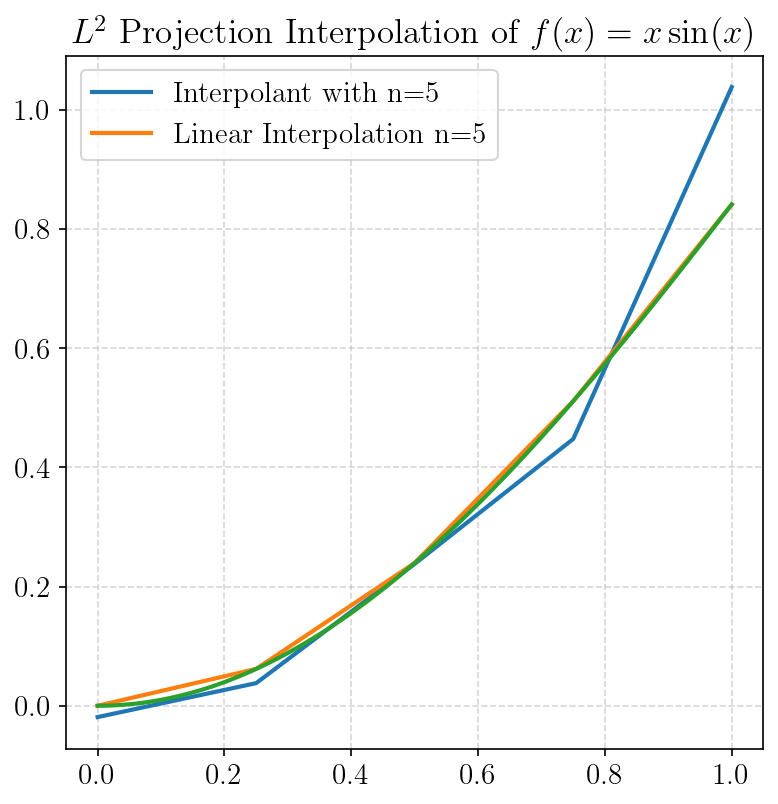

In [4]:
def f(x):
    return x * np.sin(x)


x_eval = np.linspace(0.0, 1.0, 100)
pf = L2Projector1D(x, f)
plt.plot(x, pf, label=f"Interpolant with n={len(x)}")
plt.plot(x, f(x), label=f"Linear Interpolation n={len(x)}")
plt.plot(x_eval, f(x_eval))
plt.legend()
plt.title("$L^2$ Projection Interpolation of $f(x) = x\sin(x)$")
plt.show()

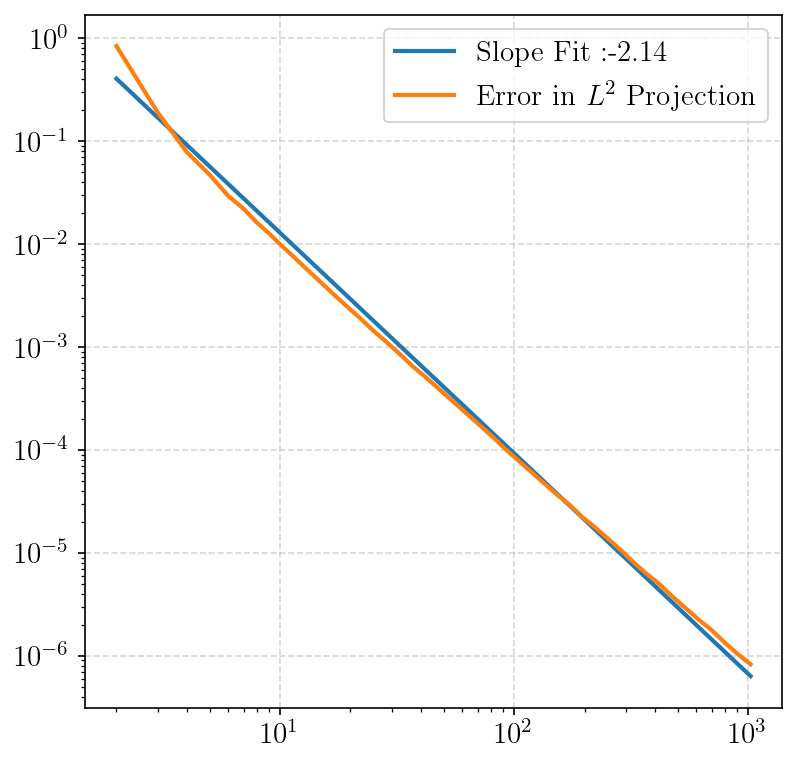

In [5]:
Ns = np.logspace(1, 10, 50, base=2, dtype=int)
errs = []
for n in Ns:
    x_conv = np.linspace(0, L, n)
    pf = L2Projector1D(x_conv, f)

    err = sp.integrate.simpson(np.abs(pf - f(x_conv)), x_conv)
    errs.append(err)

a, b = np.polyfit(np.log2(Ns), np.log2(errs), 1)
plt.loglog(Ns, 2 ** (a * np.log2(Ns) + b), label=f"Slope Fit :{a:.2f}")
plt.loglog(Ns, errs, label=f"Error in $L^2$ Projection")
plt.legend()
plt.show()

In [6]:
def make_u_h(xis, xs):
    xs = np.asarray(xs)
    xis = np.asarray(xis)

    def u_h(x):
        # Ensure array for vectorization
        x = np.asarray(x)

        # Find interval indices: i s.t. xs[i] <= x < xs[i+1]
        i = np.searchsorted(xs, x) - 1

        # clamp at boundaries
        i = np.clip(i, 0, len(xs) - 2)

        x0 = xs[i]
        x1 = xs[i + 1]
        u0 = xis[i]
        u1 = xis[i + 1]

        # linear interpolation
        t = (x - x0) / (x1 - x0)
        return u0 * (1 - t) + u1 * t

    return u_h

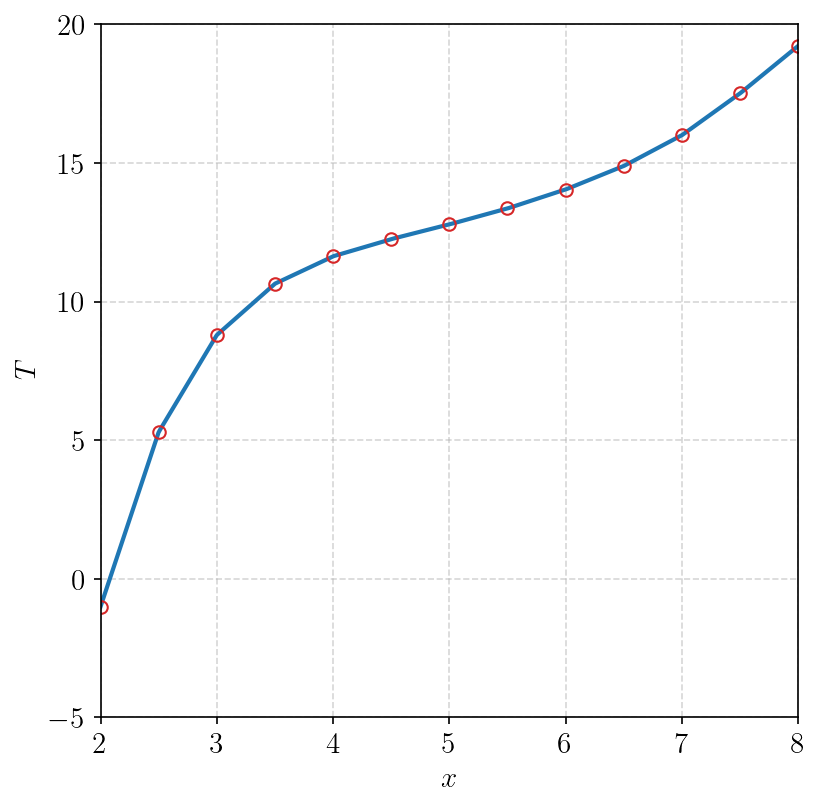

In [7]:
a, b = 2.0, 8.0
h = 0.5
N = int((b - a) // (h))
N_EVAL = 1000
KAPPA = np.array([1e6, 0.0])
G = np.array([-1, 0])


x = np.linspace(a, b, N + 1)


def conductivity(x):
    return (5 - 0.6 * x) * 0.1


def source(x):
    return 0.03 * (x - 6.0) ** 4.0


u = PoissonSolver1D(x, KAPPA, G, conductivity, source)
u_h = make_u_h(u, x)
x_eval = np.linspace(a, b, N_EVAL)
plt.plot(x_eval, u_h(x_eval))
plt.plot(x, u, "o", linestyle="None", fillstyle="none", c="C3")

plt.ylim(-5, 20)
plt.xlim(np.min(x), np.max(x))
plt.xlabel("$x$")
plt.ylabel("$T$")
plt.show()

### $$u'' = -\exp(-10^3 * (x-0.5)^2) $$
#### $$u(0)= u(L) =0$$

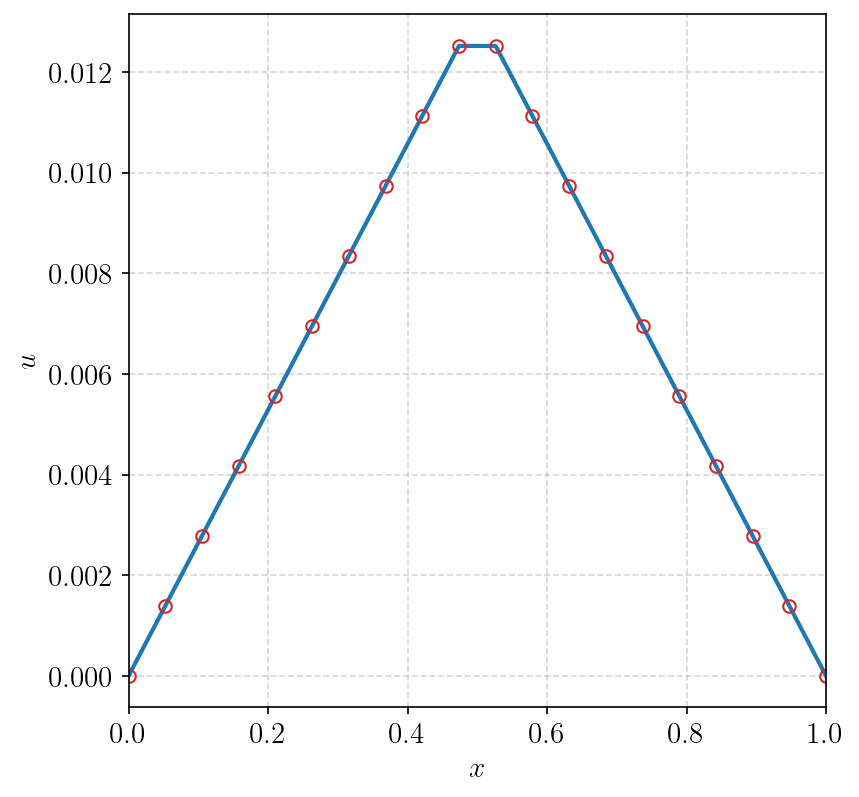

In [8]:
a, b = 0.0, 1.0
h = 0.05
N = int((b - a) // h)
KAPPA = np.array([1e6, 1e6])
N_EVAL = 1000
G = np.array(
    [
        0.0,
        0.0,
    ]
)

x = np.linspace(a, b, N + 1)


def conductivity(x):
    return 1.0


def source(x):
    return np.exp(-1000.0 * ((x - 0.5) ** 2.0))


u = PoissonSolver1D(x, KAPPA, G, conductivity, source)
u_h = make_u_h(u, x)
x_eval = np.linspace(a, b, N_EVAL)
plt.plot(x_eval, u_h(x_eval))
plt.plot(x, u, "o", linestyle="None", fillstyle="none", c="C3")
# plt.ylim(-5, 20)
plt.xlim(np.min(x), np.max(x))
plt.savefig("./finalReport/figures/FiniteElment1DSample.png")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.show()

<>:57: SyntaxWarning: invalid escape sequence '\p'
<>:57: SyntaxWarning: invalid escape sequence '\p'
/var/folders/mw/783n94t142d8bjs6w8l1hcgw0000gn/T/ipykernel_99470/1896022061.py:57: SyntaxWarning: invalid escape sequence '\p'
  plt.title("Convergence of 1D Poisson FEM for $f = -\pi^2 \sin(\pi x) $", fontsize=14)



Convergence rate: 2.006
Expected rate for P1 elements: 2.0


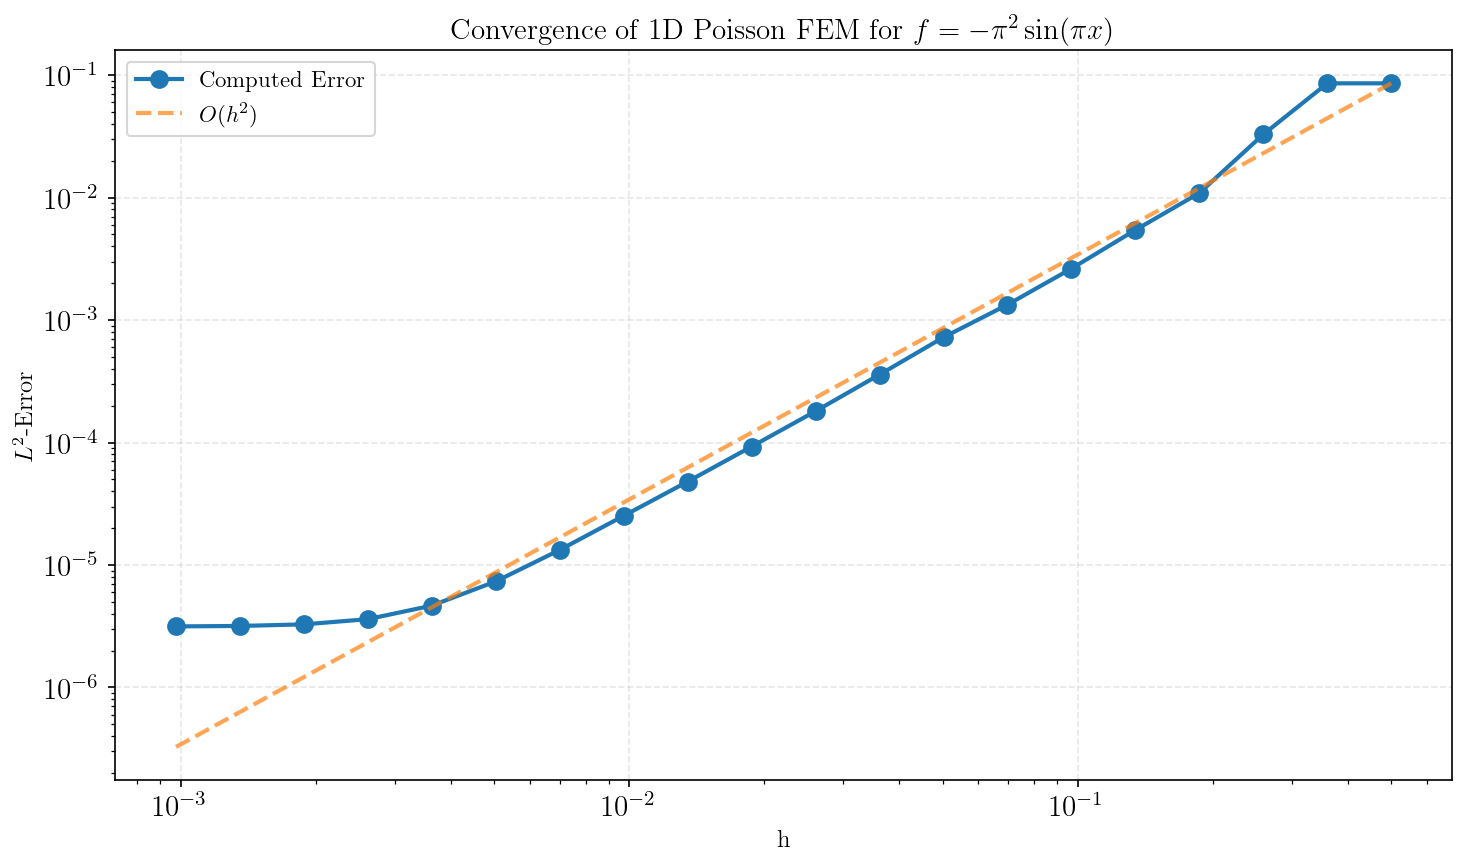

In [9]:
import numpy as np
import matplotlib.pyplot as plt

errs = []
hs = np.logspace(-1, -10, 20, base=2)


def u_true(x):
    return np.sin(np.pi * x)


for h in hs:
    a, b = 0.0, 1.0
    N = int((b - a) / h)
    KAPPA = np.array([1e6, 1e6])
    N_EVAL = 1000
    G = np.array([0.0, 0.0])

    x = np.linspace(a, b, N + 1)

    def conductivity(x):
        return 1.0

    def source(x):
        return np.pi**2.0 * np.sin(np.pi * x)

    u = PoissonSolver1D(x, KAPPA, G, conductivity, source)
    u_h = make_u_h(u, x)

    # Proper L2 error computation
    x_eval = np.linspace(a, b, N_EVAL)
    dx = x_eval[1] - x_eval[0]

    # Compute error at evaluation points
    error = u_h(x_eval) - u_true(x_eval)

    # L2 norm: sqrt(integral of error^2)
    # Using trapezoidal rule: integral ≈ dx * (f[0]/2 + f[1] + ... + f[N-1] + f[N]/2)
    L2_error_squared = dx * (
        0.5 * error[0] ** 2 + np.sum(error[1:-1] ** 2) + 0.5 * error[-1] ** 2
    )
    L2_error = np.sqrt(L2_error_squared)

    errs.append(L2_error)

errs = np.array(errs)

# Plot convergence
plt.figure(figsize=(10, 6))
plt.loglog(hs, errs, "o-", label="Computed Error", linewidth=2, markersize=8)

# Add reference lines for convergence rates
plt.loglog(hs, hs**2 * errs[0] / hs[0] ** 2, "--", label=r"$O(h^2)$", alpha=0.7)

plt.xlabel("h", fontsize=12)
plt.ylabel("$L^2$-Error", fontsize=12)
plt.title("Convergence of 1D Poisson FEM for $f = -\pi^2 \sin(\pi x) $", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Compute convergence rate
if len(hs) > 1:
    # Fit log(error) = log(C) + rate * log(h)
    log_h = np.log(hs)
    log_err = np.log(errs)

    # Use linear regression on middle portion (avoid extreme ends)
    mid_start = len(hs) // 4
    mid_end = 3 * len(hs) // 4

    coeffs = np.polyfit(log_h[mid_start:mid_end], log_err[mid_start:mid_end], 1)
    rate = coeffs[0]

    print(f"\nConvergence rate: {rate:.3f}")
    print(f"Expected rate for P1 elements: 2.0")

plt.savefig(
    "./finalReport/figures/FiniteElement1DConvergence.png", dpi=300, bbox_inches="tight"
)
plt.show()

L2 Error : 4.51e-03


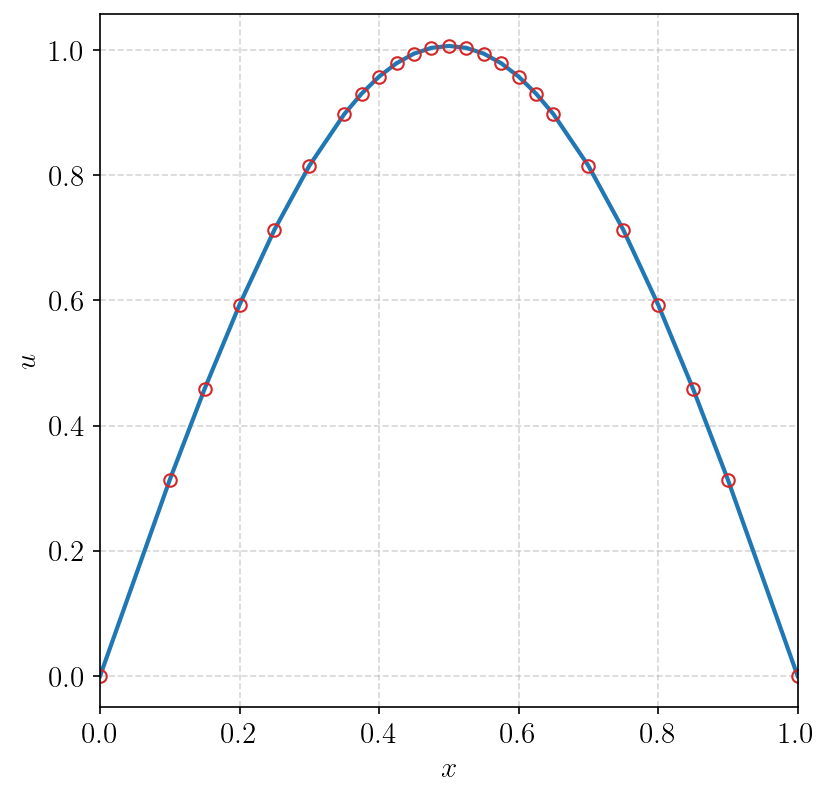

In [10]:
a, b = 0.0, 1.0
h = 0.01
N = 10
KAPPA = np.array([1e6, 1e6])


def u_true(x):
    return np.sin(np.pi * x)


G = np.array(
    [
        0.0,
        0.0,
    ]
)

x = np.linspace(a, b, N + 1)


def conductivity(x):
    return 1


def source(x):
    return np.pi**2.0 * np.sin(np.pi * x)


u, x = AdaptivePoissonSolver1D(x, KAPPA, G, conductivity, source, max_n=20, max_iter=25)
u_h = make_u_h(u, x)

# Proper L2 error computation
x_eval = np.linspace(a, b, N_EVAL)
dx = x_eval[1] - x_eval[0]

# Compute error at evaluation points
error = u_h(x_eval) - u_true(x_eval)

# L2 norm: sqrt(integral of error^2)
# Using trapezoidal rule: integral ≈ dx * (f[0]/2 + f[1] + ... + f[N-1] + f[N]/2)
L2_error_squared = dx * (
    0.5 * error[0] ** 2 + np.sum(error[1:-1] ** 2) + 0.5 * error[-1] ** 2
)
L2_error = np.sqrt(L2_error_squared)

print(f"L2 Error : {L2_error:.2e}")
plt.plot(x, u)
plt.plot(x, u, "o", linestyle="None", fillstyle="none", c="C3")
# plt.ylim(-5, 20)
plt.xlim(np.min(x), np.max(x))
plt.savefig("./finalReport/figures/AdaptiveFiniteElment1DSample.png")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.show()

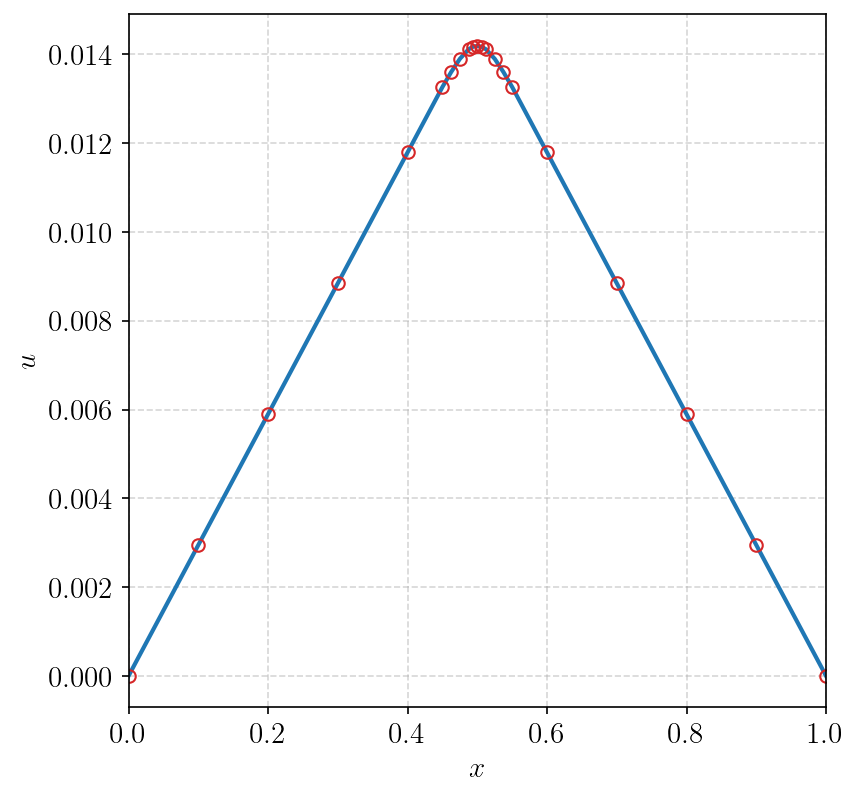

In [11]:
def u_true(x):
    return np.sin(np.pi * x)


a, b = 0.0, 1.0
h = 0.01
N = 10
KAPPA = np.array([1e6, 1e6])
G = np.array(
    [
        0.0,
        0.0,
    ]
)

x = np.linspace(a, b, N + 1)


def conductivity(x):
    return 1


def source(x):
    return np.exp(-1000.0 * ((x - 0.5) ** 2.0))


u, x = AdaptivePoissonSolver1D(x, KAPPA, G, conductivity, source, max_n=20, max_iter=25)
plt.plot(x, u)
plt.plot(x, u, "o", linestyle="None", fillstyle="none", c="C3")
# plt.ylim(-5, 20)
plt.xlim(np.min(x), np.max(x))
plt.savefig("./finalReport/figures/AdaptiveFiniteElment1DSample.png")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.show()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.000130416s, CPU 0.000181s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00284704s, CPU 0.002863s)
Info    : 115 nodes 234 elements


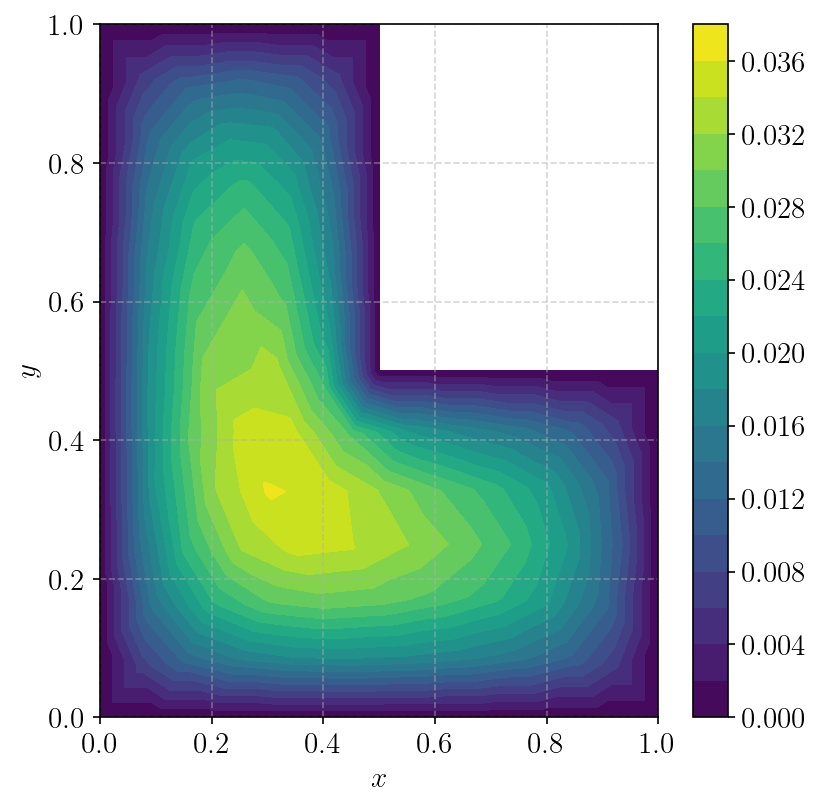

In [21]:
def f(xy):
    return np.ones_like(xy[..., 0])


def g(xy):
    return 0.0


gmsh.initialize()
gmsh.clear()

lc = 0.1


gmsh.model.add("square")
# square = gmsh.model.occ.addRectangle(
#     0, 0, 0, 1, 1
# )  ## Adding a square to the domain and return the tag of the square

gmsh.model.occ.addPoint(0, 0, 0, lc, 1)
gmsh.model.occ.addPoint(1, 0, 0, lc, 2)
gmsh.model.occ.addPoint(1, 0.5, 0, lc, 3)
gmsh.model.occ.addPoint(0.5, 0.5, 0, lc, 4)
gmsh.model.occ.addPoint(0.5, 1, 0, lc, 5)
gmsh.model.occ.addPoint(0, 1, 0, lc, 6)

gmsh.model.occ.addLine(1, 2, 1)
gmsh.model.occ.addLine(2, 3, 2)
gmsh.model.occ.addLine(3, 4, 3)
gmsh.model.occ.addLine(4, 5, 4)
gmsh.model.occ.addLine(5, 6, 5)
gmsh.model.occ.addLine(6, 1, 6)
cl = gmsh.model.occ.addCurveLoop([1, 2, 3, 4, 5, 6], 1)
square = gmsh.model.occ.addPlaneSurface([cl], 1)


gmsh.model.occ.synchronize()
pnts = gmsh.model.getBoundary(
    [(2, square)], True, True, True
)  ## Square is of dimension 2 and we get it's boundary using the tag
# print(pnts)
gmsh.model.addPhysicalGroup(1, np.array(pnts)[:, 1], 11)
gmsh.model.setPhysicalName(1, 11, "Boundary")

gmsh.model.addPhysicalGroup(2, [square], 1)
gmsh.model.setPhysicalName(2, 1, "Domain")

gmsh.model.mesh.setSize(pnts, lc)  ## Setting the size of the points
gmsh.model.mesh.generate(2)

gmsh.model.mesh.createEdges()

nodeTags, coord, param = gmsh.model.mesh.getNodes()
elementTags, nodeTagsTriangles = gmsh.model.mesh.getElementsByType(2)


nodeTags, coords, _ = gmsh.model.mesh.getNodes()
nodeTypes = np.ones((np.max(np.array(nodeTags)) + 1,), dtype=np.int32)
nodeTypes[0] = 0
numMeshNodes = len(nodeTags)
grps = gmsh.model.getPhysicalGroups()
coords = coords.reshape(-1, 3)
matrowflat = np.array([], dtype=np.int32)
matcolflat = np.array([], dtype=np.int32)
matflat = np.array([])
rhsrowflat = np.array([], dtype=np.int32)
rhsflat = np.array([])
maxNodeTag = int(np.amax(nodeTags))


for grpDim, grpTag in grps:
    grp_name = gmsh.model.getPhysicalName(grpDim, grpTag)
    if grp_name == "Boundary":  ### Identify the boundary
        entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
        for entityTag in entitiesTags:
            elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
            for elementType in elementTypes:
                elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                    elementType, entityTag
                )
                nodeTypes[nodeTags] = 2
    if grp_name == "Domain":  ### Setup the stiffness matrix for 1-D
        entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
        for entityTag in entitiesTags:
            elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
            for elementType in elementTypes:
                elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                    elementType, entityTag
                )
                numElements = len(elementTags)
                numGroupNodes = len(nodeTags)
                enode = np.array(nodeTags, dtype=np.int32).reshape((numElements, -1))
                numElementNodes = enode.shape[1]

                prop = gmsh.model.mesh.getElementProperties(2)
                uvw, weights = gmsh.model.mesh.getIntegrationPoints(2, "Gauss2")
                numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(2, uvw, "Lagrange")
                weights = np.array(weights)
                numGaussPoints = len(weights)
                sf = np.array(sf).reshape((numGaussPoints, -1))
                numcomp, dsfdu, _ = gmsh.model.mesh.getBasisFunctions(
                    2, uvw, "GradLagrange"
                )
                dsfdu = np.array(dsfdu).reshape((numGaussPoints, 3, 3))[:, :, :-1]
                qjac, qdet, qpoint = gmsh.model.mesh.getJacobians(2, uvw, 1)
                qdet = np.array(qdet).reshape((numElements, numGaussPoints))
                dxdu = np.array(qjac).reshape((numElements, numGaussPoints, 3, 3))[
                    :, :, :-1, :-1
                ]
                # jacobian stored by row, so dxdu[i][j] = dxdu_ij = dxi/duj

                # dudx[j][k] = dudx_jk = duj/dxk
                dudx = np.linalg.inv(dxdu)
                dsfdx = np.einsum("egxu,gnu->egnx", dudx, dsfdu)
                localmat = np.einsum("egik,egjk,eg,g->eij", dsfdx, dsfdx, qdet, weights)
                matcol = np.repeat(enode[:, :, None], numElementNodes, axis=2)
                matrow = np.repeat(enode[:, None, :], numElementNodes, axis=1)

                matcolflat = np.append(matcolflat, matcol.flatten())
                matrowflat = np.append(matrowflat, matrow.flatten())
                matflat = np.append(matflat, localmat.flatten())
                localrhs = np.einsum(
                    "gn,eg,eg,g->en",
                    sf,
                    qdet,
                    f(qpoint.reshape(numElements, numGaussPoints, 3)[:, :, :-1]),
                    weights,
                )
                rhsrowflat = np.append(rhsrowflat, enode.flatten())
                rhsflat = np.append(rhsflat, localrhs.flatten())

node2unknown = np.zeros(maxNodeTag + 1, dtype=np.int32)

index = 0

boundary_nodes = np.where(nodeTypes == 2)[0]
interior_nodes = np.where(nodeTypes == 1)[0]
node2unknown[interior_nodes] = np.arange(1, len(interior_nodes) + 1)
node2unknown[boundary_nodes] = np.arange(
    len(interior_nodes) + 1, len(interior_nodes) + 1 + len(boundary_nodes)
)

numUnknowns = len(interior_nodes)
index = np.max(node2unknown)
if index != numMeshNodes:
    print("Something went wrong")


unknown2node = np.zeros(numMeshNodes + 1, dtype=np.int32)
for node, unkn in enumerate(node2unknown):
    unknown2node[unkn] = node


globalmat = sps.coo_matrix(
    (matflat, (node2unknown[matcolflat] - 1, node2unknown[matrowflat] - 1)),
    shape=(numMeshNodes, numMeshNodes),
).tocsr()

globalrhs = np.zeros(numMeshNodes)
for index, node in enumerate(rhsrowflat):
    globalrhs[node2unknown[node] - 1] += rhsflat[index]

for index, node in enumerate(boundary_nodes):
    globalrhs[node2unknown[node] - 1] = g(coords[node])
for index, node in enumerate(boundary_nodes):
    globalmat[node2unknown[node] - 1, :] = 0
    globalmat[node2unknown[node] - 1, node2unknown[node] - 1] = 1


# sol = sps.linalg.spsolve(globalmat[:numUnknowns, :numUnknowns], globalrhs[:numUnknowns])
# sol = np.append(sol, np.zeros(numMeshNodes - numUnknowns))
sol = sps.linalg.spsolve(globalmat, globalrhs)

plt.tricontourf(
    coords.reshape(-1, 3)[:, 0],
    coords.reshape(-1, 3)[:, 1],
    nodeTagsTriangles.reshape(-1, 3) - 1,
    sol[node2unknown[1:] - 1],
    levels=20,
)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig("./finalReport/figures/FiniteElementSampleSolutionLDomain.png", dpi=300)
plt.show()

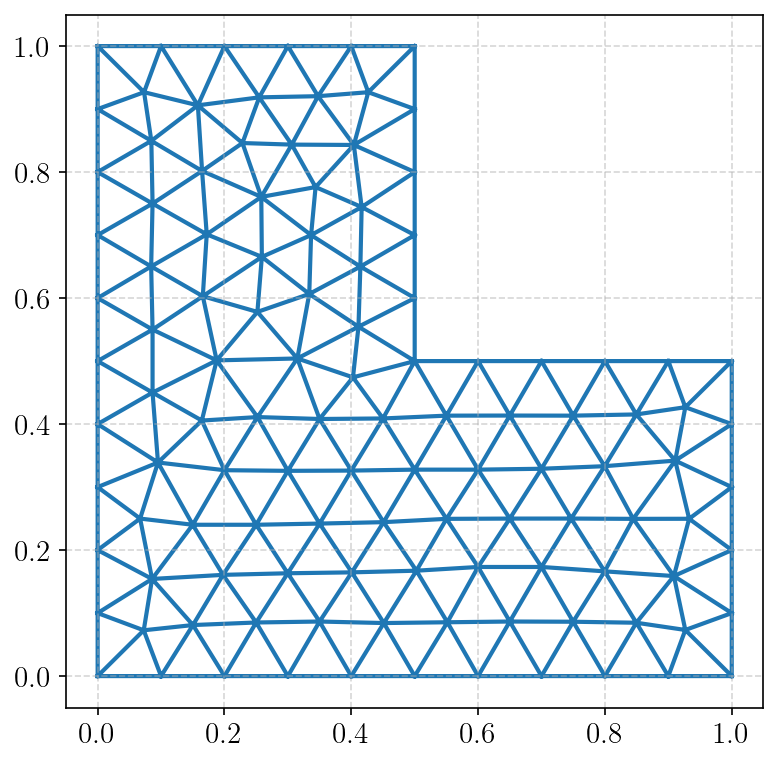

In [22]:
plt.triplot(
    coords[:, 0],
    coords[:, 1],
    nodeTagsTriangles.reshape(-1, 3) - 1,
)
plt.savefig("./finalReport/figures/LMesh.png", dpi=200)
plt.show()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 4.36672e-05s, CPU 5.5e-05s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00925588s, CPU 0.009226s)
Info    : 411 nodes 821 elements


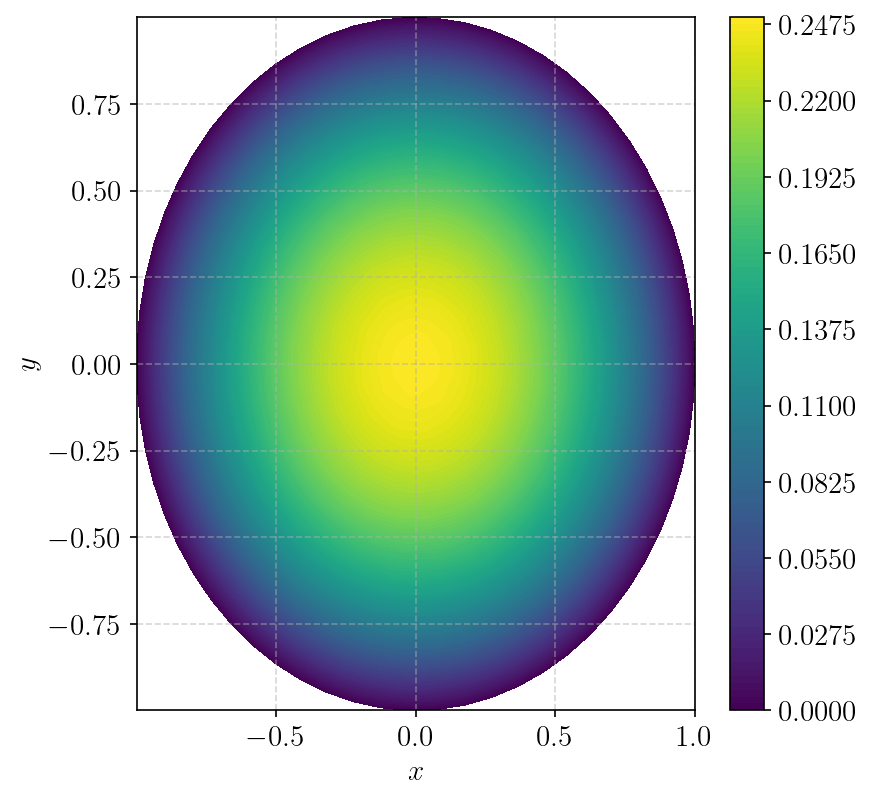

In [19]:
def f(xy):
    return np.ones_like(xy[..., 0])


def g(xy):
    return 0.0


gmsh.initialize()
gmsh.clear()

lc = 0.1


gmsh.model.add("square")
square = gmsh.model.occ.addDisk(
    0, 0, 0, 1, 1
)  ## Adding a square to the domain and return the tag of the square

# gmsh.model.occ.addPoint(0, 0, 0, lc, 1)
# gmsh.model.occ.addPoint(1, 0, 0, lc, 2)
# gmsh.model.occ.addPoint(1, 0.5, 0, lc, 3)
# gmsh.model.occ.addPoint(0.5, 0.5, 0, lc, 4)
# gmsh.model.occ.addPoint(0.5, 1, 0, lc, 5)
# gmsh.model.occ.addPoint(0, 1, 0, lc, 6)

# gmsh.model.occ.addLine(1, 2, 1)
# gmsh.model.occ.addLine(2, 3, 2)
# gmsh.model.occ.addLine(3, 4, 3)
# gmsh.model.occ.addLine(4, 5, 4)
# gmsh.model.occ.addLine(5, 6, 5)
# gmsh.model.occ.addLine(6, 1, 6)
# cl = gmsh.model.occ.addCurveLoop([1, 2, 3, 4, 5, 6], 1)
# square = gmsh.model.occ.addPlaneSurface([cl], 1)


gmsh.model.occ.synchronize()
pnts = gmsh.model.getBoundary(
    [(2, square)], True, True, True
)  ## Square is of dimension 2 and we get it's boundary using the tag
# print(pnts)
gmsh.model.addPhysicalGroup(1, np.array(pnts)[:, 1], 11)
gmsh.model.setPhysicalName(1, 11, "Boundary")

gmsh.model.addPhysicalGroup(2, [square], 1)
gmsh.model.setPhysicalName(2, 1, "Domain")

gmsh.model.mesh.setSize(pnts, lc)  ## Setting the size of the points
gmsh.model.mesh.generate(2)

gmsh.model.mesh.createEdges()

nodeTags, coord, param = gmsh.model.mesh.getNodes()
elementTags, nodeTagsTriangles = gmsh.model.mesh.getElementsByType(2)


nodeTags, coords, _ = gmsh.model.mesh.getNodes()
nodeTypes = np.ones((np.max(np.array(nodeTags)) + 1,), dtype=np.int32)
nodeTypes[0] = 0
numMeshNodes = len(nodeTags)
grps = gmsh.model.getPhysicalGroups()
coords = coords.reshape(-1, 3)
matrowflat = np.array([], dtype=np.int32)
matcolflat = np.array([], dtype=np.int32)
matflat = np.array([])
rhsrowflat = np.array([], dtype=np.int32)
rhsflat = np.array([])
maxNodeTag = int(np.amax(nodeTags))


for grpDim, grpTag in grps:
    grp_name = gmsh.model.getPhysicalName(grpDim, grpTag)
    if grp_name == "Boundary":  ### Identify the boundary
        entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
        for entityTag in entitiesTags:
            elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
            for elementType in elementTypes:
                elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                    elementType, entityTag
                )
                nodeTypes[nodeTags] = 2
    if grp_name == "Domain":  ### Setup the stiffness matrix for 1-D
        entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
        for entityTag in entitiesTags:
            elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
            for elementType in elementTypes:
                elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                    elementType, entityTag
                )
                numElements = len(elementTags)
                numGroupNodes = len(nodeTags)
                enode = np.array(nodeTags, dtype=np.int32).reshape((numElements, -1))
                numElementNodes = enode.shape[1]

                prop = gmsh.model.mesh.getElementProperties(2)
                uvw, weights = gmsh.model.mesh.getIntegrationPoints(2, "Gauss2")
                numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(2, uvw, "Lagrange")
                weights = np.array(weights)
                numGaussPoints = len(weights)
                sf = np.array(sf).reshape((numGaussPoints, -1))
                numcomp, dsfdu, _ = gmsh.model.mesh.getBasisFunctions(
                    2, uvw, "GradLagrange"
                )
                dsfdu = np.array(dsfdu).reshape((numGaussPoints, 3, 3))[:, :, :-1]
                qjac, qdet, qpoint = gmsh.model.mesh.getJacobians(2, uvw, 1)
                qdet = np.array(qdet).reshape((numElements, numGaussPoints))
                dxdu = np.array(qjac).reshape((numElements, numGaussPoints, 3, 3))[
                    :, :, :-1, :-1
                ]
                # jacobian stored by row, so dxdu[i][j] = dxdu_ij = dxi/duj

                # dudx[j][k] = dudx_jk = duj/dxk
                dudx = np.linalg.inv(dxdu)
                dsfdx = np.einsum("egxu,gnu->egnx", dudx, dsfdu)
                localmat = np.einsum("egik,egjk,eg,g->eij", dsfdx, dsfdx, qdet, weights)
                matcol = np.repeat(enode[:, :, None], numElementNodes, axis=2)
                matrow = np.repeat(enode[:, None, :], numElementNodes, axis=1)

                matcolflat = np.append(matcolflat, matcol.flatten())
                matrowflat = np.append(matrowflat, matrow.flatten())
                matflat = np.append(matflat, localmat.flatten())
                localrhs = np.einsum(
                    "gn,eg,eg,g->en",
                    sf,
                    qdet,
                    f(qpoint.reshape(numElements, numGaussPoints, 3)[:, :, :-1]),
                    weights,
                )
                rhsrowflat = np.append(rhsrowflat, enode.flatten())
                rhsflat = np.append(rhsflat, localrhs.flatten())

node2unknown = np.zeros(maxNodeTag + 1, dtype=np.int32)

index = 0

boundary_nodes = np.where(nodeTypes == 2)[0]
interior_nodes = np.where(nodeTypes == 1)[0]
node2unknown[interior_nodes] = np.arange(1, len(interior_nodes) + 1)
node2unknown[boundary_nodes] = np.arange(
    len(interior_nodes) + 1, len(interior_nodes) + 1 + len(boundary_nodes)
)

numUnknowns = len(interior_nodes)
index = np.max(node2unknown)
if index != numMeshNodes:
    print("Something went wrong")


unknown2node = np.zeros(numMeshNodes + 1, dtype=np.int32)
for node, unkn in enumerate(node2unknown):
    unknown2node[unkn] = node


globalmat = sps.coo_matrix(
    (matflat, (node2unknown[matcolflat] - 1, node2unknown[matrowflat] - 1)),
    shape=(numMeshNodes, numMeshNodes),
).tocsr()

globalrhs = np.zeros(numMeshNodes)
for index, node in enumerate(rhsrowflat):
    globalrhs[node2unknown[node] - 1] += rhsflat[index]

for index, node in enumerate(boundary_nodes):
    globalrhs[node2unknown[node] - 1] = g(coords[node])
for index, node in enumerate(boundary_nodes):
    globalmat[node2unknown[node] - 1, :] = 0
    globalmat[node2unknown[node] - 1, node2unknown[node] - 1] = 1


# sol = sps.linalg.spsolve(globalmat[:numUnknowns, :numUnknowns], globalrhs[:numUnknowns])
# sol = np.append(sol, np.zeros(numMeshNodes - numUnknowns))
sol = sps.linalg.spsolve(globalmat, globalrhs)

plt.tricontourf(
    coords.reshape(-1, 3)[:, 0],
    coords.reshape(-1, 3)[:, 1],
    nodeTagsTriangles.reshape(-1, 3) - 1,
    sol[node2unknown[1:] - 1],
    levels=100,
)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig("./finalReport/figures/FiniteElementSampleSolutionDiskDomain.png", dpi=300)

plt.show()

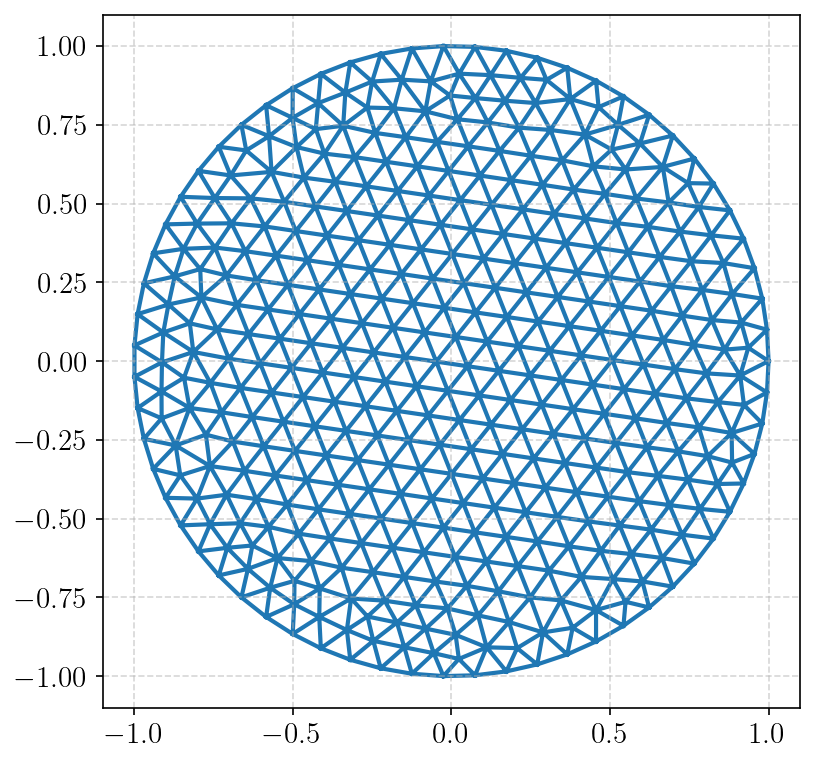

In [20]:
plt.triplot(
    coords[:, 0],
    coords[:, 1],
    nodeTagsTriangles.reshape(-1, 3) - 1,
)
plt.savefig("./finalReport/figures/DiskMesh.png", dpi=200)
plt.show()

Info    : Clearing all models and views...
Info    : Done clearing all models and views
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000109291s, CPU 0.000157s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00214387s, CPU 0.002142s)
Info    : 98 nodes 198 elements
L2 Error: 0.025061880122475726
Relative L2 Error: 0.05012378004729458


/Users/prathamlalwani/miniconda3/envs/fenicsx-env/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/var/folders/mw/783n94t142d8bjs6w8l1hcgw0000gn/T/ipykernel_99470/1074446578.py:206: RankWarning: Polyfit may be poorly conditioned
  sl, b = np.polyfit(np.log2(lcs), np.log2(errs), 1)


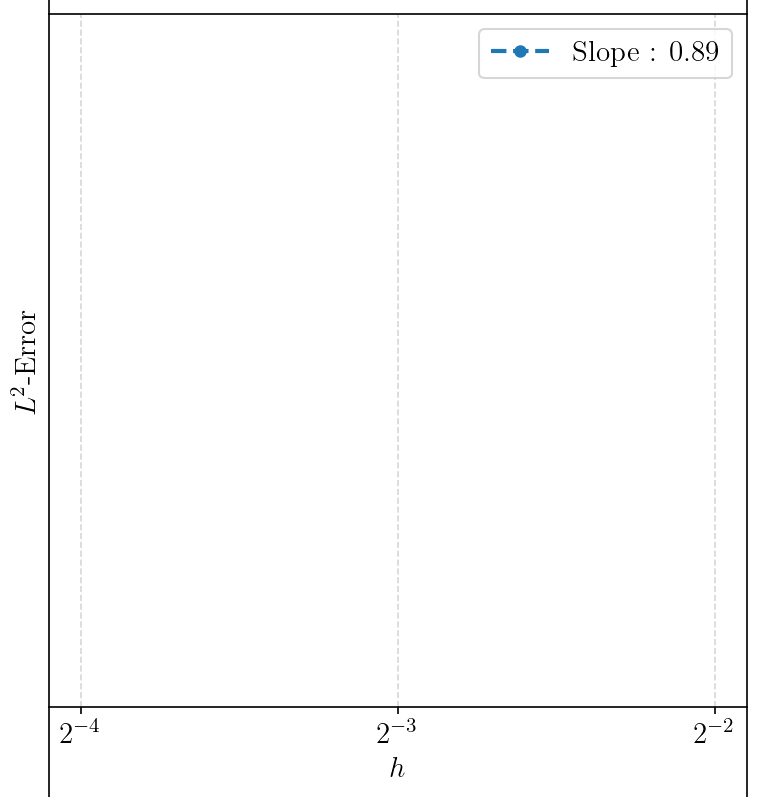

In [15]:
def f(xy):
    return 2 * np.pi**2.0 * np.sin(np.pi * xy[..., 0]) * np.sin(np.pi * xy[..., 1])


def g(xy):
    return np.sin(np.pi * xy[0]) * np.sin(np.pi * xy[1])


def u_true(xy):
    return np.sin(np.pi * xy[..., 0]) * np.sin(np.pi * xy[..., 1])


gmsh.initialize()
gmsh.clear()

lc = 0.01


class Mesh:
    def __init__(self):
        self.vtags, vxyz, _ = gmsh.model.mesh.getNodes()
        self.vxyz = vxyz.reshape((-1, 3))
        vmap = dict({j: i for i, j in enumerate(self.vtags)})
        self.triangles_tags, evtags = gmsh.model.mesh.getElementsByType(2)
        evid = np.array([vmap[j] for j in evtags])
        self.triangles = evid.reshape((self.triangles_tags.shape[-1], -1))


lcs = np.logspace(-3, -7, 10, base=2)[:1]
errs = []
for i, lc in enumerate(lcs):
    gmsh.model.add(f"square{i}")
    square = gmsh.model.occ.addRectangle(
        0, 0, 0, 1, 1
    )  ## Adding a square to the domain and return the tag of the square

    gmsh.model.occ.synchronize()
    pnts = gmsh.model.getBoundary(
        [(2, square)], True, True, True
    )  ## Square is of dimension 2 and we get it's boundary using the tag

    gmsh.model.addPhysicalGroup(1, np.array(pnts)[:, 1], 11)
    gmsh.model.setPhysicalName(1, 11, "Boundary")

    gmsh.model.addPhysicalGroup(2, [square], 1)
    gmsh.model.setPhysicalName(2, 1, "Domain")

    gmsh.model.mesh.setSize(pnts, lc)  ## Setting the size of the points
    gmsh.model.mesh.generate(2)

    gmsh.model.mesh.createEdges()

    nodeTags, coord, param = gmsh.model.mesh.getNodes()
    elementTags, nodeTagsTriangles = gmsh.model.mesh.getElementsByType(2)

    nodeTags, coords, _ = gmsh.model.mesh.getNodes()
    nodeTypes = np.ones((np.max(np.array(nodeTags)) + 1,), dtype=np.int32)
    nodeTypes[0] = 0
    numMeshNodes = len(nodeTags)
    grps = gmsh.model.getPhysicalGroups()
    coords = coords.reshape(-1, 3)
    matrowflat = np.array([], dtype=np.int32)
    matcolflat = np.array([], dtype=np.int32)
    matflat = np.array([])
    rhsrowflat = np.array([], dtype=np.int32)
    rhsflat = np.array([])
    maxNodeTag = int(np.amax(nodeTags))

    for grpDim, grpTag in grps:
        grp_name = gmsh.model.getPhysicalName(grpDim, grpTag)
        if grp_name == "Boundary":  ### Identify the boundary
            entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
            for entityTag in entitiesTags:
                elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
                for elementType in elementTypes:
                    elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                        elementType, entityTag
                    )
                    nodeTypes[nodeTags] = 2
        if grp_name == "Domain":  ### Setup the stiffness matrix for 1-D
            entitiesTags = gmsh.model.getEntitiesForPhysicalGroup(grpDim, grpTag)
            for entityTag in entitiesTags:
                elementTypes = gmsh.model.mesh.getElementTypes(grpDim, entityTag)
                for elementType in elementTypes:
                    elementTags, nodeTags = gmsh.model.mesh.getElementsByType(
                        elementType, entityTag
                    )
                    numElements = len(elementTags)
                    numGroupNodes = len(nodeTags)
                    enode = np.array(nodeTags, dtype=np.int32).reshape(
                        (numElements, -1)
                    )
                    numElementNodes = enode.shape[1]

                    prop = gmsh.model.mesh.getElementProperties(2)
                    uvw, weights = gmsh.model.mesh.getIntegrationPoints(2, "Gauss2")
                    numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(
                        2, uvw, "Lagrange"
                    )
                    weights = np.array(weights)
                    numGaussPoints = len(weights)
                    sf = np.array(sf).reshape((numGaussPoints, -1))
                    numcomp, dsfdu, _ = gmsh.model.mesh.getBasisFunctions(
                        2, uvw, "GradLagrange"
                    )
                    dsfdu = np.array(dsfdu).reshape((numGaussPoints, 3, 3))[:, :, :-1]
                    qjac, qdet, qpoint = gmsh.model.mesh.getJacobians(2, uvw, 1)
                    qdet = np.array(qdet).reshape((numElements, numGaussPoints))
                    dxdu = np.array(qjac).reshape((numElements, numGaussPoints, 3, 3))[
                        :, :, :-1, :-1
                    ]
                    # jacobian stored by row, so dxdu[i][j] = dxdu_ij = dxi/duj

                    # dudx[j][k] = dudx_jk = duj/dxk
                    dudx = np.linalg.inv(dxdu)
                    dsfdx = np.einsum("egxu,gnu->egnx", dudx, dsfdu)
                    localmat = np.einsum(
                        "egik,egjk,eg,g->eij", dsfdx, dsfdx, qdet, weights
                    )
                    matcol = np.repeat(enode[:, :, None], numElementNodes, axis=2)
                    matrow = np.repeat(enode[:, None, :], numElementNodes, axis=1)

                    matcolflat = np.append(matcolflat, matcol.flatten())
                    matrowflat = np.append(matrowflat, matrow.flatten())
                    matflat = np.append(matflat, localmat.flatten())
                    localrhs = np.einsum(
                        "gn,eg,eg,g->en",
                        sf,
                        qdet,
                        f(qpoint.reshape(numElements, numGaussPoints, 3)[:, :, :-1]),
                        weights,
                    )
                    rhsrowflat = np.append(rhsrowflat, enode.flatten())
                    rhsflat = np.append(rhsflat, localrhs.flatten())

    node2unknown = np.zeros(maxNodeTag + 1, dtype=np.int32)

    index = 0

    boundary_nodes = np.where(nodeTypes == 2)[0]
    interior_nodes = np.where(nodeTypes == 1)[0]
    node2unknown[interior_nodes] = np.arange(1, len(interior_nodes) + 1)
    node2unknown[boundary_nodes] = np.arange(
        len(interior_nodes) + 1, len(interior_nodes) + 1 + len(boundary_nodes)
    )

    numUnknowns = len(interior_nodes)
    index = np.max(node2unknown)
    if index != numMeshNodes:
        print("Something went wrong")

    unknown2node = np.zeros(numMeshNodes + 1, dtype=np.int32)
    for node, unkn in enumerate(node2unknown):
        unknown2node[unkn] = node

    globalmat = sps.coo_matrix(
        (matflat, (node2unknown[matcolflat] - 1, node2unknown[matrowflat] - 1)),
        shape=(numMeshNodes, numMeshNodes),
    ).tocsr()

    globalrhs = np.zeros(numMeshNodes)
    for index, node in enumerate(rhsrowflat):
        globalrhs[node2unknown[node] - 1] += rhsflat[index]

    for index, node in enumerate(boundary_nodes):
        globalrhs[node2unknown[node] - 1] = g(coords[node])
    for index, node in enumerate(boundary_nodes):
        globalmat[node2unknown[node] - 1, :] = 0
        globalmat[node2unknown[node] - 1, node2unknown[node] - 1] = 1

    # sol = sps.linalg.spsolve(globalmat[:numUnknowns, :numUnknowns], globalrhs[:numUnknowns])
    # sol = np.append(sol, np.zeros(numMeshNodes - numUnknowns))
    sol = sps.linalg.spsolve(globalmat, globalrhs)

    m = Mesh()

    uvw, weights = gmsh.model.mesh.getIntegrationPoints(2, "Gauss2")
    jac, det, pt = gmsh.model.mesh.getJacobians(2, uvw)
    numcomp, sf, _ = gmsh.model.mesh.getBasisFunctions(2, uvw, "Lagrange")
    sf = np.array(sf).reshape((len(weights), -1))
    weights = np.array(weights)

    qx = np.array(pt).reshape((m.triangles.shape[0], len(weights), 3))
    det = np.abs(np.array(det).reshape((m.triangles.shape[0], len(weights))))

    node_tags_in_triangles = m.vtags[m.triangles]  # Shape: (num_elements, 3)

    sol_at_vertices = sol[node2unknown[1:] - 1][node_tags_in_triangles - 1]

    u_fem = np.dot(sol_at_vertices, sf.T)

    u_exact = u_true(qx[:, :, :2])
    err_squared_per_element = np.sum((u_fem - u_exact) ** 2 * det * weights, axis=1)

    L2_error = np.sqrt(np.sum(err_squared_per_element))

    print(f"L2 Error: {L2_error}")
    print(
        f"Relative L2 Error: {L2_error / np.sqrt(np.sum(u_exact**2 * det * weights))}"
    )

    errs.append(L2_error)
    # x = coords[node2unknown]

    # err =
sl, b = np.polyfit(np.log2(lcs), np.log2(errs), 1)
plt.plot(lcs, errs, label=f"Slope : {sl:.2f}", marker="o", markersize=5, linestyle="--")
plt.plot(lcs, 2 ** (sl * np.log2(lcs) + b))
plt.xscale("log", base=2)
plt.yscale("log")
plt.xlabel("$h$")
plt.ylabel("$L^2$-Error")
plt.legend()
plt.savefig("./finalReport/figures/FiniteElementConvergence2D", dpi=300)
plt.show()

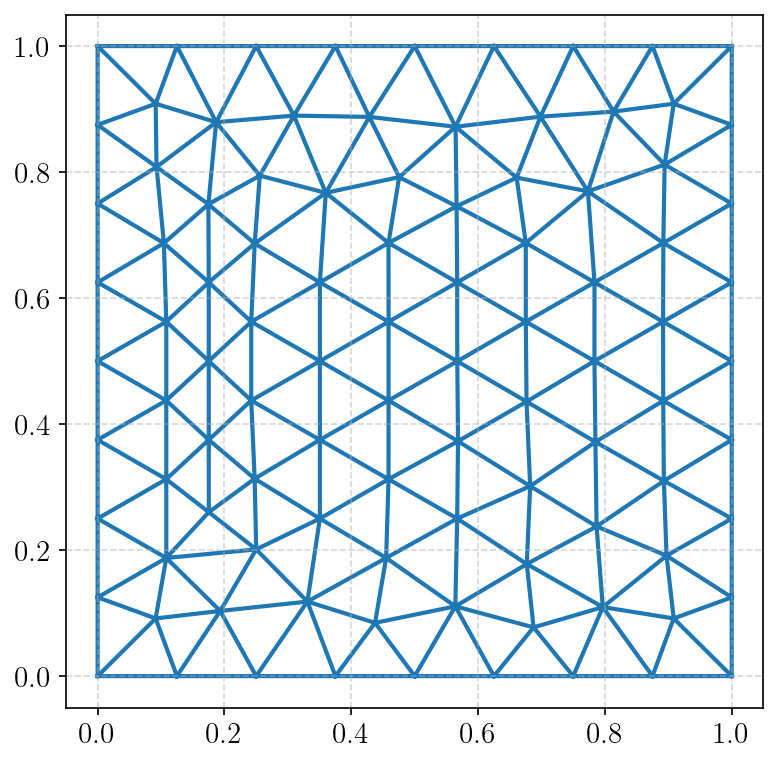

In [16]:
plt.triplot(
    coords[:, 0],
    coords[:, 1],
    nodeTagsTriangles.reshape(-1, 3) - 1,
)
plt.savefig("./finalReport/figures/RectangularMesh.png", dpi=200)
plt.show()

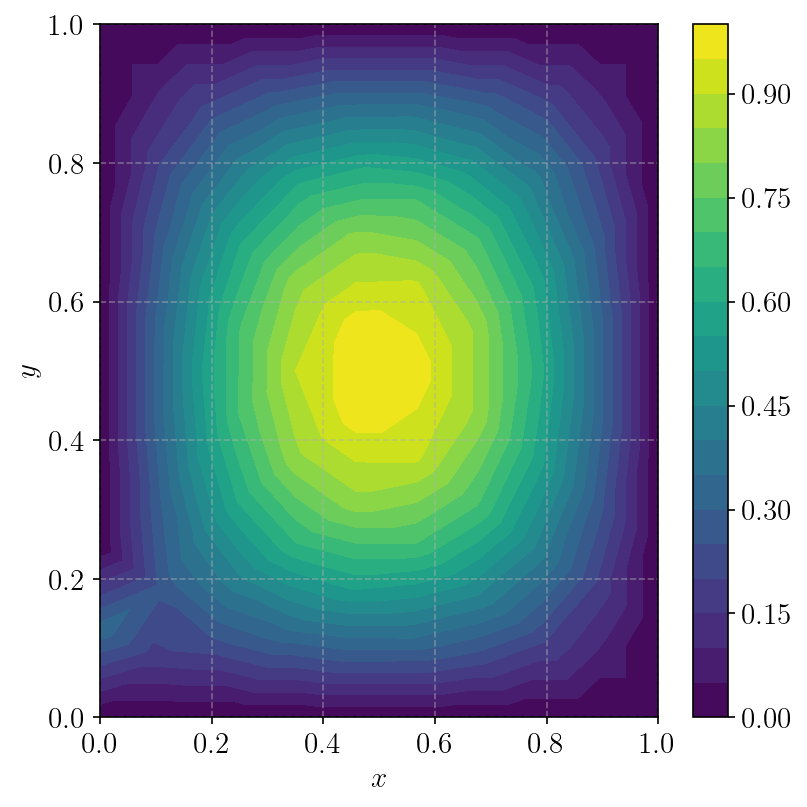

In [17]:
plt.tricontourf(coords[:, 0], coords[:, 1], sol[node2unknown[1:] - 1], levels=20)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig("./finalReport/figures/FiniteElementSampleSolutionRectDomain.png", dpi=300)
plt.show()

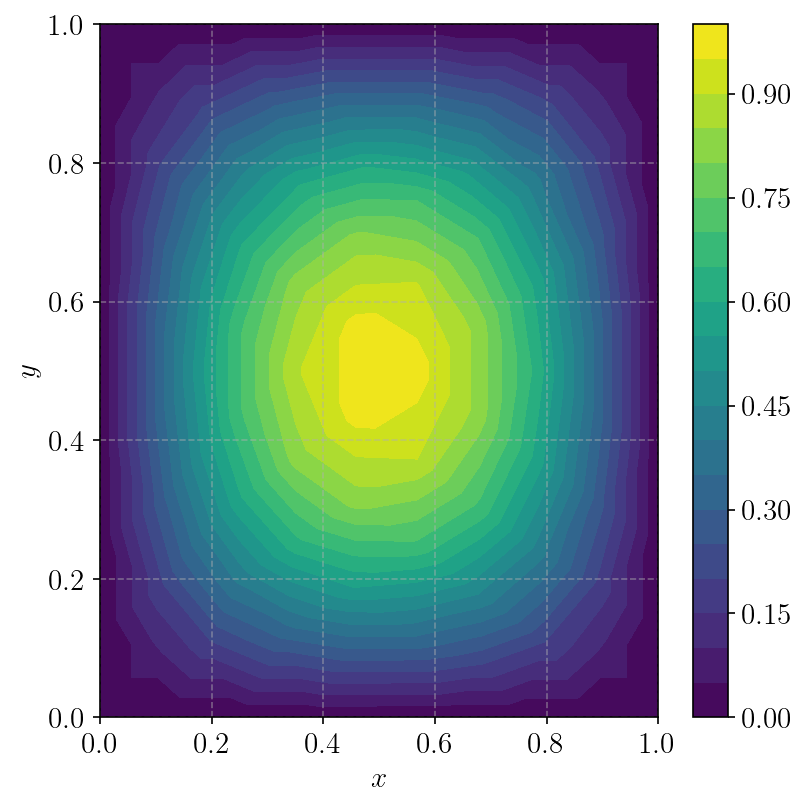

In [18]:
plt.tricontourf(coords[:, 0], coords[:, 1], u_true(coords[:, :-1]), levels=20)
plt.colorbar()
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.savefig("./finalReport/figures/TrueSolutionRectDomain.png", dpi=300)
plt.show()